In [1]:
import pickle
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import Counter
from itertools import combinations
import community
import pandas as pd
import os
import bz2
import json
from random import sample

In [3]:
with open("EoBoR_linklistlist.pickle",'rb') as f:
    linklist = pickle.load(f)    
#2016-12, 2017-01, 2017-02, 2017-03

`filenamevar` determines what the filename extension is, for simple version control (consider learning how to do this in git more effectively in the future). 

| Value  | Meaning                                                                                                          |
|--------|------------------------------------------------------------------------------------------------------------------|
| [None] | Networks are constructed from subreddit data where nodes are users and edges indicate >1 threads commented in common between the two users within that month.  |
| excl   | Networks are constructed excluding the posts from subreddit itself.                                              |
| excl3  | Networks are constructed with the conditions of `excl` with a threads-in-common threshold of 3 to create edges.  |

In [60]:
filenamevar = 'excl'

In [ ]:
# linklist_t = [{} for thing in linklist] #Transpose of the linklist to make it threads by user instead of users by thread
# for i,month in tqdm(enumerate(linklist)):
#     for thread in month:
#         for user in month[thread]:
#             if user not in linklist_t[i]:
#                 linklist_t[i][user] = {}
#             linklist_t[i][user][thread] = month[thread][user]

In [4]:
def networkByMonth(month):
    threadchat = {}
    smallthreadcount = 0
    #Get all the instances where two people chatted in a thread
    for thread in month:
        if len(month[thread].keys())<=1:
            smallthreadcount+=1
            continue
        for x,y in combinations(month[thread].keys(),2):
            if str("%s,%s"%(sorted([x,y])[0],sorted([x,y])[1])) not in threadchat:
                threadchat[str("%s,%s"%(sorted([x,y])[0],sorted([x,y])[1]))] = 0
            threadchat[str("%s,%s"%(sorted([x,y])[0],sorted([x,y])[1]))] += 1
    print("%i of the %i threads had only one response."%(smallthreadcount,len(month)))
    
    g = nx.Graph()
    for key in threadchat:
        if threadchat[key]<=1:
            continue
        x,y = key.split(",")
        g.add_edge(x,y,weight=threadchat[key])
    return g

In [7]:
for i,month in enumerate(linklist):
    g_month = networkByMonth(month)
    with open("EoBoR_%i_%s.gexf"%(i,filenamevar),'wb') as f:
        nx.write_gexf(g_month,f)

220274 of the 232955 threads had only one response.
267119 of the 279755 threads had only one response.
206807 of the 212469 threads had only one response.
202233 of the 207316 threads had only one response.


### Observations

* It looks like the population of original users drop by half, and surprisingly the number of edges drops ten-fold. 
 * 1280->570 nodes, 11k->1.8k edges. 
* Before the ban, it looks like there was two major communities, one homogeneous and one mixed, based on modularity class. Not sure why OpenOrd splits into those two groups, given that other methods don't do that. 
* After the ban, this structure looks similar but slightly broken? Maybe looking at assortativity would help. 
* Concerns about comparing networks with a completely different population. 
* A lot of edges occur in the subredddit. 
 
### Questions 1

* Is there a correspondence between the communities between months? 
* How much overlap between populations?
* Can you track which subreddits people went to?

### How much overlap between populations across months?

In [8]:
networklist = [nx.read_gexf('EoBoR_%i_%s.gexf'%(i,filenamevar)) for i in range(4)]

In [9]:
usersets = [set(x.nodes()) for x in networklist]

In [10]:
print("Of the %i users in Dec16, %i were found in Jan17."%(len(usersets[0]),len(usersets[0]&usersets[1])))
print("Of the %i users in Jan17, %i were found in Feb17."%(len(usersets[1]),len(usersets[1]&usersets[2])))
print("Of the %i users in Feb17, %i were found in Mar17."%(len(usersets[2]),len(usersets[2]&usersets[3])))

Of the 1076 users in Dec16, 841 were found in Jan17.
Of the 1280 users in Jan17, 474 were found in Feb17.
Of the 570 users in Feb17, 355 were found in Mar17.


### Is there a correspondence between communities across months?

In [11]:
partitions = [community.best_partition(x) for x in networklist]

In [12]:
#Top 5 largest communities
top5comms = [sorted(list(enumerate([partitions[i].values().count(comm) for comm in range(max(partitions[i].values()))])), key=lambda x: x[1], reverse = True)[0:5] for i in range(len(partitions))]
top5comms

[[(0, 445), (1, 392), (2, 138), (3, 33), (5, 32)],
 [(0, 495), (1, 420), (5, 151), (3, 124), (2, 69)],
 [(1, 215), (5, 91), (2, 62), (8, 59), (6, 39)],
 [(5, 125), (1, 103), (2, 70), (7, 69), (0, 44)]]

So what I want this to do is to give me a the community with the best overlap for each community above

for each of the largest communities in a given month network:
    set of individuals in that community
    take each of the other given month networks
    for each top community in that network:
        create sets of the users in those communities
        Take the intersection for each of these with the original community
        Report the one that accounts for the most original community users

In [13]:
def usersInComm(d,comm):
    return set(k for k,v in d.items() if v==comm)

def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [14]:
#Figure out which community has the most overlap
the_dumbest_meta = nx.DiGraph()
monthkey = {0: 'Dec', 1: 'Jan', 2: 'Feb', 3:'Mar'}

for i,month in enumerate(top5comms):
    for comm_num,comm_val in month:
        #print "Month %i, community number %i"%(i,comm_num)
        origin = monthkey[i]+str(comm_num)
        original_community_set = usersInComm(partitions[i],comm_num)
        for x in range(len(top5comms)):
            #print x
            results = []
            for y in range(len(top5comms[x])):
                test_community_set = usersInComm(partitions[x],top5comms[x][y][0])
                diff = float(len(original_community_set & test_community_set))/len(original_community_set)
                if 1>diff>=0.2:
                    #results.append( (top5comms[x][y][0], truncate(diff,2)) )
                    destination = monthkey[x]+str(top5comms[x][y][0])
                    the_dumbest_meta.add_edge(origin,destination,weight=diff)

In [15]:
nx.write_gexf(the_dumbest_meta,'the_dumbest_meta_%s.gexf'%filenamevar)

<img src="the_dumbest_meta2.png">

### Questions 2

It seems like there's some correspondence between months. List of to-do: 

* Export modularity class from gephi and look at the cases of communities you see visually. 
* See the overlap between the community in question (comm-oq). 

List of questions:

1. Is the dense weighted cluster consistent over time?
2. Right now, you're comparing the out (posts not in the sub) before and after. This only answers the question "Does removing this subreddit affect other communities?". So you also need to compare the in and see whether the in+out(after_ban) = total(before_ban). 
3. ? To defend the idea that the community has changed, you can construct null configuration models before and after the network changes and then excise the same users that are lost across the ban date. Then you can see if the real networks are statistically different from the nulls. 

In [ ]:
def gephiCommunityMapper(csv_filename, ntwk):
    df = pd.read_csv(csv_filename)
    mod_partitions = {x:df.get_value(df.loc[df['Label']==x].index[0],'modularity_class') for x in df['Label'].tolist()}
        #df.loc[df['Label']==x].index[0]  <-- This part gets the index of the label (username) that you want
        #df.get_value gets the thing at the row and column, where row has to be indexed row
    nx.set_node_attributes(ntwk,'community',mod_partitions)
    return ntwk

In [ ]:
gephimodfiles = ['dec2016_gephimod.csv','jan2017_gephimod.csv','feb2017_gephimod.csv','mar2017_gephimod.csv']

In [ ]:
gephinets = []
for x,y in zip(gephimodfiles,networklist):
    gephinets.append( gephiCommunityMapper(x,y) )

In [ ]:
comms_in_q = [8,14,14,12]
gephinet_sets = []
for i,thing in enumerate(gephinets):
    gephinet_sets.append( set([x for x,y in nx.get_node_attributes(thing,'community').items() if y==comms_in_q[i]]) )

In [ ]:
for x in range(len(gephinet_sets)-1):
    print "Total number within the community for month %i"%x
    print len(gephinet_sets[x])
    print "Overlap with next month"
    print len(gephinet_sets[x] & gephinet_sets[x+1])

### Findings from previous section

When looking at the really connected part of the networks, 68/122 (55%) of the users are repeats from Dec to Jan, and 41/91 (45%) of the users are carry-overs from Jan to Feb. This is much greater than the overall carryover, so these are probably the same communities. 

If the community survived the ban, then they must be talking somewhere, so let's see where they are talking. 

In [ ]:
max(nx.get_node_attributes(gephinets[0],'community').values())

Get the threads that communities participated in

In [ ]:
users_in_comms_all = []

for g in gephinets:
    comms_in_net = []
    commvals = nx.get_node_attributes(g,'community')
    for i in range(max(commvals.values())):
        comms_in_net.append(set([x for x,y in commvals.items() if y==i]))
    users_in_comms_all.append(comms_in_net)

In [ ]:
#What threads correspond with each community?

threadcomm = []

for i, monthdata in enumerate(users_in_comms_all):
    threadcommmonth = {}
    for ct in tqdm(linklist[i]):
        if len(linklist[i][ct].keys())>1:
            for commnum in range(len(monthdata)):
                if len(set(linklist[i][ct].keys()) & monthdata[commnum])>=2: #If more than two users from that community appeared in the thread
                    if commnum not in threadcommmonth:
                        threadcommmonth[commnum] = set({})
                    threadcommmonth[commnum].add(ct)
    threadcomm.append(threadcommmonth)

In [ ]:
threadcomm

In [ ]:
#For every file
    #Load each document
    #If the thread matches the one in the record
    #Put it into the aggregator with the label

comm_subreddits = []

#Pull user data based on subreddit
for i,filename in enumerate(os.listdir("reddit_data/reddit_bzs/")):
    print filename
    monthvar = {}
    month = threadcomm[i]
    with bz2.BZ2File("reddit_data/reddit_bzs/"+filename,'rb') as f:
        for line in tqdm(f):
            doc = json.loads(line)
            #Checking every community
            #for month in threadcomm:
            for comm in month:
                if comm not in monthvar:
                    monthvar[comm] = {}
                for threadname in month[comm]:
                    if doc['parent_id']==threadname:
                        if doc['subreddit'] not in monthvar[comm]:
                            monthvar[comm][doc['subreddit']] = 0
                        monthvar[comm][doc['subreddit']] += 1
    comm_subreddits.append(monthvar)

In [ ]:
with open("threadcomm.pickle",'wb') as f:
    pickle.dump(threadcomm,f)

I ran the above on another computer. The results are in comm_subs.pickle. 

#### Analyzing comm_subs

In [16]:
with open("comm_subs.pickle",'r') as f:
    comm_subs = pickle.load(f)

In [31]:
for i,thing in enumerate(comm_subs):
    print("The month is %i ============================================================="%i)
    for comm in thing:
        print comm
        #for sub in sorted(thing[comm].items(), key=lambda x: x[1],reverse=True)[0:5]:
        #    print str(sub)+",",
        if 'MGTOW' in thing[comm]:
            print "MGTOW",
            print thing[comm][MGTOW]
        print "\n"

The month is 0 =============================================================
0
(u'MGTOW', 2186), (u'The_Donald', 1307), (u'milliondollarextreme', 1083), (u'TheRedPill', 158), (u'uncensorednews', 148), 

1
(u'news', 3718), (u'StarWars', 3409), 

2
(u'Anarcho_Capitalism', 1303), (u'Libertarian', 860), (u'pics', 759), (u'The_Donald', 261), (u'DebateAltRight', 84), 

3
(u'AskReddit', 9604), (u'worldnews', 1675), (u'MHOCMP', 693), (u'DebateFascism', 532), (u'PoliticalDiscussion', 531), 

4
(u'nfl', 78634), (u'CFB', 21610), (u'detroitlions', 4312), (u'fantasyfootball', 3287), (u'movies', 1473), 

5
(u'The_Donald', 132207), (u'AskReddit', 83133), (u'pcmasterrace', 39599), (u'MMA', 30826), (u'politics', 30007), 

6
(u'worldnews', 154), (u'politics', 6), 

7
(u'The_Donald', 1687), (u'metacanada', 721), (u'worldnews', 704), (u'CringeAnarchy', 126), (u'canada', 89), 

8
(u'AskReddit', 10821), (u'DebateAltRight', 4037), (u'politics', 3053), (u'The_Donald', 3039), (u'videos', 2993), 

9
(u'TumblrIn

In [24]:
thing[comm]

{u'australia': 49}

## Doing statistics

The basic idea is that if the structure of the network changed drastically, then it should have very different network properties than a random subgraph of the previous month. 

In [61]:
networklist = [nx.read_gexf('EoBoR_%i_%s.gexf'%(i,filenamevar)) for i in range(4)]

In [62]:
networklist_lens = [len(thing) for thing in networklist]

In [63]:
networklist_lens

[729, 836, 570, 497]

In [64]:
def subsample(g,trim_num):
    if len(g)<=trim_num:
        raise ValueError('Subgraph parameters are larger than the original graph.')
    a = g.copy()
    random_nodes = sample(a.nodes(),len(a)-trim_num)
    a.remove_nodes_from(random_nodes)
    return a

def subsetTrials(orig,final,n_trials=100):
    #betweenness = []
    average_degree = []
    diameter = []
    #connected_components = []
    #avg_shortest_path_len = []
    #assortativity = []
    density = []
    average_clustering = []
    num_cliques = []
    transitivity = []
    rich_club = []
    for x in tqdm(range(n_trials)):
        norm_g = subsample(orig,len(final))
        #Betweenness
        #betweenness.append(nx.betweenness_centrality(norm_g,weight='weight'))
        #Average degree
        average_degree.append(np.mean(norm_g.degree().values()))
        #Diameter
        giant = max(nx.connected_component_subgraphs(norm_g), key=len)
        diameter.append(nx.diameter(giant))
        #Modularity
        #Connected components
        #connected_components.append(nx.number_connected_components(norm_g))
        #Average path length
        #avg_shortest_path_len.append(nx.average_shortest_path_length(giant,weight='weight'))
        #Degree assortativity
        #edge_weights = nx.get_edge_attributes(norm_g,'weight')
        #nx.set_edge_attributes( norm_g, 'weight', {key:int(val) for key,val in edge_weights.items()} )
        #assortativity.append(nx.degree_assortativity_coefficient(norm_g,weight='weight'))
        density.append(nx.density(norm_g))
        average_clustering.append(nx.average_clustering(norm_g))
        num_cliques.append(nx.graph_number_of_cliques(norm_g))
        transitivity.append(nx.transitivity(norm_g))
        rich_club.append(nx.rich_club_coefficient(norm_g))
    return average_degree, diameter, density, average_clustering, num_cliques, transitivity, rich_club

In [65]:
#Distribution test
average_degree, diameter, density, average_clustering, num_cliques, transitivity, rich_club = subsetTrials(networklist[1],networklist[2],n_trials=500)

100%|██████████| 500/500 [20:30<00:00,  2.24s/it]


In [36]:
from matplotlib import pyplot

6.8862877193


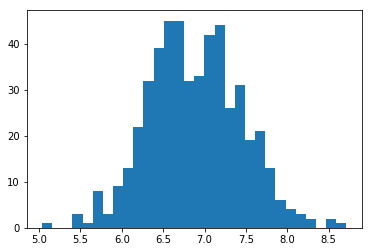

8.99


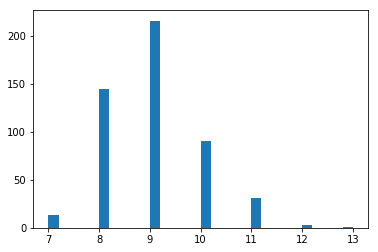

0.012102438874


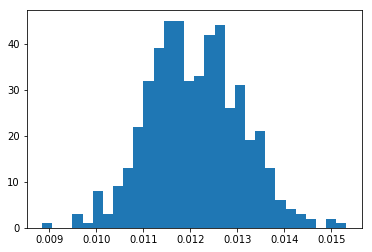

0.25766156223


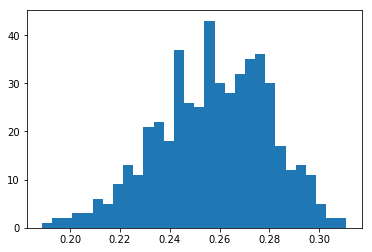

1168.498


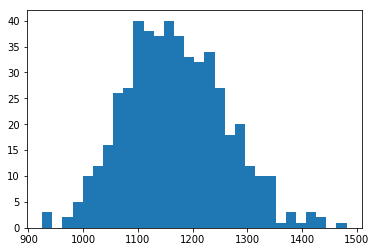

0.236276715334


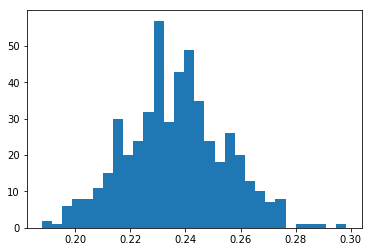

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [71]:
for thing in [average_degree, diameter, density, average_clustering, num_cliques, transitivity, rich_club]:
    print np.mean(thing)
    plt.hist(thing,bins=30)
    plt.show()

In [38]:
#t test or whatever
import scipy.stats as stats

In [67]:
#Average degree
real_average_degree = np.mean(networklist[2].degree().values())
#Diameter
giant = max(nx.connected_component_subgraphs(networklist[2]), key=len)
real_diameter = nx.diameter(giant)
#Connected components
real_connected_components = nx.number_connected_components(networklist[2])
#Average shortest path length
real_avg_shortest_path_len = nx.average_shortest_path_length(giant,weight='weight')
#Degree assortativity
real_edge_weights = nx.get_edge_attributes(networklist[2],'weight')
nx.set_edge_attributes( networklist[2],'weight', {key:int(val) for key,val in real_edge_weights.items()} )
real_assortativity = nx.degree_assortativity_coefficient(networklist[2],weight='weight')

real_density = nx.density(networklist[2])
real_average_clustering = nx.average_clustering(networklist[2])
real_num_cliques = nx.graph_number_of_cliques(networklist[2])
real_transitivity = nx.transitivity(networklist[2])
#real_rich_club = nx.rich_club_coefficient(networklist[2])

In [47]:
print real_average_degree
print real_diameter
print real_avg_shortest_path_len
print real_assortativity

6.57894736842
8
8.16816883422
0.00462368229246


In [40]:
zscores_average_degree = stats.zscore([real_average_degree] + average_degree)
zscores_diameter = stats.zscore([real_diameter] + diameter)
zscores_connected_components = stats.zscore([real_connected_components] + connected_components)
zscores_avg_path = stats.zscore([real_avg_shortest_path_len] + avg_shortest_path_len)
zscores_assort = stats.zscore([real_assortativity] + assortativity)

In [41]:
print(zscores_average_degree[0])
print(zscores_diameter[0])
print(zscores_connected_components[0])
print(zscores_avg_path[0])
print(zscores_assort[0])

-1.49287892904
0.634099226919
-5.81495966795
8.36781179688
6.96608968762


In [42]:
print stats.ks_2samp(average_degree, [real_average_degree])
#print stats.ks_2samp(diameter, [real_diameter]) <--Not valid because discrete
#print stats.ks_2samp(connected_components, [real_connected_components]) <--Not valid because discrete
print stats.ks_2samp(avg_shortest_path_len, [real_avg_shortest_path_len])
print stats.ks_2samp(assortativity, [real_assortativity])

Ks_2sampResult(statistic=0.93599999999999994, pvalue=0.1416676730662311)
Ks_2sampResult(statistic=1.0, pvalue=0.097451698078349178)
Ks_2sampResult(statistic=1.0, pvalue=0.097451698078349178)


split here

In [68]:
print real_average_degree
print real_diameter
print real_density
print real_average_clustering
print real_num_cliques
print real_transitivity
#print real_rich_club

6.57894736842
8
0.0115622976598
0.226451418678
1051
0.272801591411


In [69]:
zscores_average_degree = stats.zscore([real_average_degree] + average_degree)
zscores_diameter = stats.zscore([real_diameter] + diameter)
zscores_density = stats.zscore([real_density] + density)
zscores_average_clustering = stats.zscore([real_average_clustering] + average_clustering)
zscores_num_cliques = stats.zscore([real_num_cliques] + num_cliques)
zscores_transitivity = stats.zscore([real_transitivity] + transitivity)
#zscores_rich_club = stats.zscore([real_rich_club] + rich_club)

In [70]:
print zscores_average_degree[0]
print zscores_diameter[0]
print zscores_density[0]
print zscores_average_clustering[0]
print zscores_num_cliques[0]
print zscores_transitivity[0]
#print zscores_rich_club[0]

-0.54935839706
-1.03570991859
-0.54935839706
-1.38244168628
-1.27927928409
2.01505836999


In [59]:
print stats.ks_2samp(average_degree, [real_average_degree])
print stats.ks_2samp(diameter, [real_diameter])
print stats.ks_2samp(density, [real_density])
print stats.ks_2samp(average_clustering, [real_average_clustering])
print stats.ks_2samp(num_cliques, [real_num_cliques])
print stats.ks_2samp(transitivity, [real_transitivity])
#print stats.ks_2samp(rich_club, [real_rich_club])

Ks_2sampResult(statistic=0.93199999999999994, pvalue=0.14489874205381176)
Ks_2sampResult(statistic=0.5, pvalue=0.84444254262661533)
Ks_2sampResult(statistic=0.93199999999999994, pvalue=0.14489874205381176)
Ks_2sampResult(statistic=0.88400000000000001, pvalue=0.1884718473445251)
Ks_2sampResult(statistic=0.998, pvalue=0.098635004684842473)
Ks_2sampResult(statistic=1.0, pvalue=0.097451698078349178)
